# RNA-seq Workshop: Bioinformatics Practical

[![Binder](https://notebooks.gesis.org/binder/badge_logo.svg)](https://notebooks.gesis.org/binder/v2/gh/imperial-genomics-facility/rnaseq-notebook-image/master?urlpath=lab%2Ftree%2Fexamples%2Frnaseq_example_1_v0.0.1.ipynb)

* __Notebook version__: `v0.0.1`
* __Created by:__ `Imperial BRC Genomics Facility`
* __Maintained by:__ `Imperial BRC Genomics Facility`
* __Docker image:__ `TO DO`
* __Github repository:__ [imperial-genomics-facility/rnaseq-notebook-image](https://github.com/imperial-genomics-facility/rnaseq-notebook-image)
* __Created on:__ `2020-May-22 13:57`
* __Contact us:__ [Imperial BRC Genomics Facility](https://www.imperial.ac.uk/medicine/research-and-impact/facilities/genomics-facility/contact/)
* __License:__ [Apache License 2.0](https://github.com/imperial-genomics-facility/scanpy-notebook-image/blob/master/LICENSE)

In this practical session, we will investigate the basic processes required to analyse RNA-Seq experiments. Using data from the Illumina platform, we will work through quality checking (QC), read trimming, read alignment (mapping), visualization of read alignments, read counts, normalization, and differential expression and visualization using R.

## Supplementary Information 

__Note__ – some of these pages will require you to log in to view them using your normal college username/password

* File Formats:
  * https://wiki.imperial.ac.uk/display/BioInfoSupport/Bioinformatics+File+Formats

* Additional information on Programs used:
  * http://www.ic.ac.uk/bioinformatics-data-science-group/resources/software/next-generation-sequencing-ngs-software/


* List of software Used:
  * FastQC
  * MultiQC
  * Trim Galore
  * STAR
  * featureCounts
  * Samtools
  * DESeq2 (R Bioconductor package)
  * RSubread (R Bioconductor package)

The data for today’s tutorial was obtained from the Griffith Lab and is available using this link:

  http://genomedata.org/rnaseq-tutorial/

The dataset consists of 3 replicates of a pool of tumour samples and 3 replicates of a pool of ‘normal’ samples. The libraries were prepared using the TruSeq Stranded Total RNA Sample Prep Kit and all samples were sequenced on 2 lanes of a HiSeq200 using 100bp paired end reads.


## Get data

We are downloading fastq files from Box server.

In [1]:
%%time
!wget -q -O /tmp/practical.tar \
  https://imperialcollegelondon.box.com/shared/static/9q169p5ggm52v7npkrxo5h55b6t2qttt.tar
!mkdir -p fastq_files ;cd fastq_files;tar -xf /tmp/practical.tar

CPU times: user 825 ms, sys: 287 ms, total: 1.11 s
Wall time: 32.8 s


Lets check the downloaded fastq files.

In [2]:
ll fastq_files 

total 355136
-rw-r--r-- 1 vmuser 25955505 Mar 18  2017 hcc1395_normal_rep1_r1.fastq.gz
-rw-r--r-- 1 vmuser 30766759 Mar 18  2017 hcc1395_normal_rep1_r2.fastq.gz
-rw-r--r-- 1 vmuser 25409781 Mar 18  2017 hcc1395_normal_rep2_r1.fastq.gz
-rw-r--r-- 1 vmuser 30213083 Mar 18  2017 hcc1395_normal_rep2_r2.fastq.gz
-rw-r--r-- 1 vmuser 25132378 Mar 18  2017 hcc1395_normal_rep3_r1.fastq.gz
-rw-r--r-- 1 vmuser 30174637 Mar 18  2017 hcc1395_normal_rep3_r2.fastq.gz
-rw-r--r-- 1 vmuser 30361801 Mar 18  2017 hcc1395_tumor_rep1_r1.fastq.gz
-rw-r--r-- 1 vmuser 35887220 Mar 18  2017 hcc1395_tumor_rep1_r2.fastq.gz
-rw-r--r-- 1 vmuser 29769613 Mar 18  2017 hcc1395_tumor_rep2_r1.fastq.gz
-rw-r--r-- 1 vmuser 35254974 Mar 18  2017 hcc1395_tumor_rep2_r2.fastq.gz
-rw-r--r-- 1 vmuser 29472281 Mar 18  2017 hcc1395_tumor_rep3_r1.fastq.gz
-rw-r--r-- 1 vmuser 35241854 Mar 18  2017 hcc1395_tumor_rep3_r2.fastq.gz


You can check the fastq file format for `hcc1395_normal_rep1_r1.fastq.gz` using the following command

In [3]:
!zcat fastq_files/hcc1395_normal_rep1_r1.fastq.gz|head -4

@K00193:38:H3MYFBBXX:4:1101:10003:44458/1
TTCCTTATGAAACAGGAAGAGTCCCTGGGCCCAGGCCTGGCCCACGGTTGTCAAGGCACATCATTGCCAGCAAGCTGAAGCATACCAGCAGCCACAACCTAGATCTCATTCCCAACCCAAAGTTCTGACTTCTGTACAAACTCGTTTCCAG
+
AAFFFKKKKKKKKKKKKKKKKKKKKKKKKFKKFKKKKF<AAKKKKKKKKKKKKKKKKFKKKFKKKKKKKKKKKFKAFKKKKKKKKKKKKKKKKKKKKKKKKKKKFKKKKKKKKKKKKFKKKKKKKKKKKKFKFFKKKKKKKKKKKKFKKKK

gzip: stdout: Broken pipe


HINT: You can remind yourself of the format by looking at 
https://wiki.imperial.ac.uk/display/BioInfoSupport/Bioinformatics+File+Formats

Briefly:
* __Line 1__: Sequence identifier, prefixed with '@' at the beginning of the line
* __Line 2__:   Sequence
* __Line 3__:   A '+' symbol delimiting the sequence from the following line. In older files this contained a second copy of the sequence identifier after the '+', but this is unnecessary and results in considerable extra data having to be stored.
* __Line 4__:  The quality scores, encoded as text (ASCII characters) rather than numbers.

Fastq files are large and are commonly stored in a compressed format – created using a program called gzip. Such compressed files have a .gz on the end of their file name. Some tools can work directly on the file in its compressed form as you have seen.

Now you can count how many reads there are in this fastq file: 

In [4]:
!zcat fastq_files/hcc1395_normal_rep1_r1.fastq.gz| echo $((`wc -l`/4))

331958


This means read in the contents of a compressed (gzipped) fastq file line by line (`zcat`) and send that (`|` pipe symbol) to a command that counts the total number of lines in the file, divides that number by 4  <code>((\`wc -l \`/ 4))</code> and writes the result to the screen (`echo`). The back quotes tell the operating system to run the command  wc -l and evaluate the result and feed that into the rest of the command – here to divide it by 4 and write the result out. Please note that forward quotes (‘) will not have the same effect.

__How many reads did you find?__

__Why did you divide by 4 in the command above?__


## Prepare sample list

In [5]:
sample_list = [
    {'sample_name':'hcc1395_normal_rep1',
     'R1':'fastq_files/hcc1395_normal_rep1_r1.fastq.gz',
     'R2':'fastq_files/hcc1395_normal_rep1_r2.fastq.gz'},
    {'sample_name':'hcc1395_normal_rep2',
     'R1':'fastq_files/hcc1395_normal_rep2_r1.fastq.gz',
     'R2':'fastq_files/hcc1395_normal_rep2_r2.fastq.gz'},
    {'sample_name':'hcc1395_normal_rep3',
     'R1':'fastq_files/hcc1395_normal_rep3_r1.fastq.gz',
     'R2':'fastq_files/hcc1395_normal_rep3_r2.fastq.gz'},
    {'sample_name':'hcc1395_tumor_rep1',
     'R1':'fastq_files/hcc1395_tumor_rep1_r1.fastq.gz',
     'R2':'fastq_files/hcc1395_tumor_rep1_r2.fastq.gz'},
    {'sample_name':'hcc1395_tumor_rep2',
     'R1':'fastq_files/hcc1395_tumor_rep2_r1.fastq.gz',
     'R2':'fastq_files/hcc1395_tumor_rep2_r2.fastq.gz'},
    {'sample_name':'hcc1395_tumor_rep3',
     'R1':'fastq_files/hcc1395_tumor_rep3_r1.fastq.gz',
     'R2':'fastq_files/hcc1395_tumor_rep3_r2.fastq.gz'}
]

## Quality Assessment

Now we should assess the quality of our dataset. To do this we can use a program called FastQC.

FastQC can be run interactively through a graphical interface or on the command line (by typing commands). Running the program on the command line is much faster if you are using more than one or 2 input files than going through a graphical interface. Here, we will process files from the command line and then view on a browser. All the information that the program needs to run can be specified on the command line as shown below as an example.

For clarity, we can also split this command over multiple lines (as would be done in a script as part of an analysis pipeline), using the `\` (backslash) character to indicate the end of each line except the last.

```bash
fastqc \                # program name
  -o outputdir \        # name of directory to put output files in (optional – default is fastq directory)
  --(no)extract \       # do or do not extract the zipped output files once created -default is yes
  -f fastq  \           # input file format which can be set to e.g. SAM, BAM or fastq
  -c contaminantfile \  # screen for a specific contaminant sequence using contents of named file (optional)
  seqfile               # name of input file – which can be multiple files named one after another
```

We will now run FastQC on all of the files in the `fastq_files` directory. Once this has finished and the prompt returns, we can have a look at the output html files in the `fastqc_output` directory by loading any of them into a browser. 

In [6]:
import os

In [7]:
%%time
!mkdir -p fastqc_output
for sample_entry in sample_list:
    sample_name = sample_entry.get('sample_name')
    R1_fastq = sample_entry.get('R1')
    R2_fastq = sample_entry.get('R2')
    print('Running FastQC for sample {0}'.format(sample_name))
    !fastqc \
      -q \
      -o fastqc_output \
      -t 1 \
      $R1_fastq $R2_fastq

Running FastQC for sample hcc1395_normal_rep1
Running FastQC for sample hcc1395_normal_rep2
Running FastQC for sample hcc1395_normal_rep3
Running FastQC for sample hcc1395_tumor_rep1
Running FastQC for sample hcc1395_tumor_rep2
Running FastQC for sample hcc1395_tumor_rep3
CPU times: user 2.89 s, sys: 931 ms, total: 3.82 s
Wall time: 1min 54s


Take a look at a reports to get an idea of the quality of the data you have been given. Each section of the report is given a 
_traffic light_ summary on the left pane to highlight major issues- more detail is shown in the right hand pane when you select that section, as shown in the figure above.

__N.B.__ RNA-Seq per-base sequence content plots frequently show a warning here (orange or even red), due to bias at the start of reads – introduced by random hexamer priming/ fragmentation using transposases. This is true for most RNA-Seq libraries where a number of different kmers are enriched at the 5’ read end, affecting around the first 10-12 bases, and you often don’t need to trim or correct it.  Kmer content may also show an orange warning  - libraries derived from random hexamer priming almost always show sharp spikes and warnings. Some of your samples are also showing warnings on Duplicate Sequences – again a common feature of RNA-Seq libraries where over-duplication of highly expressed transcripts is tolerated in order to be able to see lowly expressed ones.

The report provides summary statistics about the numbers of reads, per-base sequence quality, per sequence GC content, sequence duplication levels and adapter content (for a detailed explanation of all the plots in the report please see the FastQC help pages). Remember, the Phred quality score represents the probability of an incorrect base call and is a measure of the reliability of each nucleotide in the read:

$$Q=-10*log_{10} P$$

where Q is the Phred quality value and P the probability of error so a Phred quality score of 20 indicates a probability of error in the base call of 1 in 100 (99% accuracy). The quality values in the original fastq files are encoded in ASCII characters rather than numbers and these are interpreted by FastQC. After interpreting the full FastQC report, for other types of NGS analyses, we might want to filter or trim reads.  

For RNA-seq with the current generation of alignment algorithms, read trimming may not be required, though we include it in this practical (see _Del Fabbro et al 2013 - An Extensive Evaluation of Read Trimming Effects on Illumina NGS Data Analysis. PLOS ONE_ http://dx.doi.org/10.1371/journal.pone.0085024).

When you have seen enough, close FastQC by simply closing the tab visualising the report.

## Trimming the Reads

In the FastQC reports for each read you can see how the quality of the reads can differ. To improve read quality they can be trimmed. Different programmes will successfully remove duplicate sequences present in the reads (adapter contamination) and can also help trim the reads if they are below a quality threshold. There are a variety of programmes for trimming reads, for this tutorial we will be using [Trim Galore](https://www.bioinformatics.babraham.ac.uk/projects/trim_galore/).

Make sure to save the trimmed reads in a new directory so that they can’t get confused with the pre-processed reads! To do this we will need to make a new directory `trimmed_output`.

To run Trim Galore, use a command of the following format for each pair of reads (example given for a single pair of reads):

```bash
trim_galore \              # program name
  --illumina \             # trims the first 13bp of the Illumina universal adapter
  -o trimmed_reads \       # specifies the output directory for the trimmed reads
  --length 90 \            # length below which the trimmed reads will be discarded
  -q 25 \                  # minimum quality score for undiscarded reads
  --paired \               # indicate that the reads are paired
  s1_r1.fq.gz s1_r2.fq.gz  # fastq files
```

Trim Galore will output a trimmed file and a trimming report for each pair of input files.

In [8]:
%%time
!mkdir -p trimmed_output
for sample_entry in sample_list:
    sample_name = sample_entry.get('sample_name')
    R1_fastq = sample_entry.get('R1')
    R2_fastq = sample_entry.get('R2')
    print('Running Trim Galore for sample {0}'.format(sample_name))
    trim_galor_log = os.path.join(
                       'trimmed_output',
                       '{0}_trim_galor.log'.format(sample_name))
    !trim_galore \
      --illumina \
      --length 90 \
      -q 25 \
      --paired \
      -o trimmed_output \
      $R1_fastq $R2_fastq 2> $trim_galor_log
    r1_trimmed_fastq = 'trimmed_output/{0}_r1_val_1.fq.gz'.format(sample_name)
    r2_trimmed_fastq = 'trimmed_output/{0}_r2_val_2.fq.gz'.format(sample_name)
    sample_entry.update({'R1_trimmed':r1_trimmed_fastq})
    sample_entry.update({'R2_trimmed':r2_trimmed_fastq})

Running Trim Galore for sample hcc1395_normal_rep1
Running Trim Galore for sample hcc1395_normal_rep2
Running Trim Galore for sample hcc1395_normal_rep3
Running Trim Galore for sample hcc1395_tumor_rep1
Running Trim Galore for sample hcc1395_tumor_rep2
Running Trim Galore for sample hcc1395_tumor_rep3
CPU times: user 7.93 s, sys: 2.55 s, total: 10.5 s
Wall time: 5min 7s


In order to better understand how trimming reads affects their quality, we will once again run FastQC on the data. 

In [9]:
%%time
!mkdir -p trimmed_fastqc
sample_name = sample_list[0].get('sample_name')
R1_fastq = sample_list[0].get('R1_trimmed')
R2_fastq = sample_list[0].get('R2_trimmed')
print('Running FastQC for sample {0}'.format(sample_name))
!fastqc \
  -q \
  -o trimmed_fastqc \
  -t 1 \
  $R1_fastq $R2_fastq

Running FastQC for sample hcc1395_normal_rep1


Now open both the FastQC reports.

__What are the differences between the raw and the trimmed data?__

## Read Alignment

In this step, we will map (align) the trimmed reads in the fastq files onto a copy of the appropriate reference genome in order to identify which exons and transcripts the reads correspond to. In order to do this, we require an annotated reference genome containing the actual consensus sequence itself, and also a list of known genomic features and their corresponding coordinates on the sequence. If this is not available (for instance if the reference genome of your organism of interest is not available, is not annotated or is of overall poor quality), RNA-seq analysis is still possible but a different approach is required – de novo transcriptome assembly. Many next generation mapping programs are available, however STAR, BWA, and Bowtie variants (Bowtie2, TopHat) are commonly used for RNA-Seq analyses. Here, as a reference is available, we will use STAR to align our reads. You can find more information about Star at http://chagall.med.cornell.edu/RNASEQcourse/STARmanual.pdf.  
Most mapping programs will do a good job where alignments are unambiguous, but will each deal slightly differently with reads that map ambiguously to more than one region in the genome, reads containing errors, and more particularly with how reads are modelled across splice junctions at intron/exon boundaries (remember primary RNA transcripts are spliced to remove introns). 

__Some words of CAUTION__ (for work outside of this practical session)– when using these genome indices and annotations as reference data in the later steps of analysis, it is extremely important that the SAME genome version is used throughout an analysis. Even data derived from the same human genome build (e.g. hg19) may differ in content depending on its origin. This may have a subtle or not-so-subtle effect on your analyses and is a very common point of failure; particularly when re-analysing data. 
Index versions are specific to the program that they were indexed for – often even down to the program VERSION number, and may simply not be recognised by other program versions. Annotations for human come in 2 main ‘flavours’ – from Ensembl or UCSC and the feature name conventions are different. This means that you need to use a genome sequence file and an annotation file from the SAME build and same origin for all steps in your analysis. If you build your BAM alignment against one genome, don’t expect to be able to view it correctly against an annotation set from a different origin…. 
Other differences to consider – some human genome reference sets include all the integrated endogenous retroviruses, others have had them removed, some annotations include all the non-coding RNA annotations from rFAM, others do not etc. etc. You should consider what to use, based on your biological area of interest.

For the purposes of this practical we have created an index only of chromosome 22. To create an indexed genome in STAR, a fasta file of the genome and a GTF file containing annotated transcripts are both required. Creating a genome index in star will output: binary genome sequence, suffix arrays, text chromosome names/lengths, splice junctions coordinates, and transcripts/genes information.

For this practical, we are downloading gene annotation from [GENCODE](https://www.gencodegenes.org/human/) and extracting the entries for chromosome 22. Also, we are fetching the chromosome 22 fasta files from [UCSC genome browser](https://genome.ucsc.edu/).

In [10]:
%%time
!mkdir -p star_ref
!wget -q -O star_ref/gencode.v34.annotation.gtf.gz \
  http://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_34/gencode.v34.annotation.gtf.gz
!zcat star_ref/gencode.v34.annotation.gtf.gz|grep '^chr22' > star_ref/chr22_gencode.v34.annotation.gtf
!wget -q -O star_ref/chr22.fa.gz \
  http://hgdownload.soe.ucsc.edu/goldenPath/hg38/chromosomes/chr22.fa.gz
!gzip -d star_ref/chr22.fa.gz

__STAR__ is a mapping program designed specifically to for high accuracy and fast alignments of RNA-Seq data  
STAR takes a collection of run-time information from the command-line that sets how the program will behave. Brief help on the available options is available as below by typing: 

```bash
STAR
```

Minimum information to run STAR  is of the form 
```bash
  STAR [options] --genomeDir REFERENCE --readFilesIn R1.fq R2.fq
```

Options change how the program runs and you can set them or not as required. Other input, such as the location of the input file(s) and indexed genome are obligatory.

Mapping is a computationally intensive process and would take several hours to run on a complete dataset. To allow us to illustrate the process, we have made a much smaller dataset to run against a single human chromosome. Even this will take some minutes to run. 

In [11]:
%%time
!STAR \
  --runThreadN 1 \
  --runMode genomeGenerate \
  --genomeDir star_ref \
  --genomeFastaFiles star_ref/chr22.fa \
  --sjdbGTFfile star_ref/chr22_gencode.v34.annotation.gtf \
  --sjdbOverhang 99

May 22 12:13:42 ..... started STAR run
May 22 12:13:42 ... starting to generate Genome files
May 22 12:13:44 ... starting to sort Suffix Array. This may take a long time...
May 22 12:13:44 ... sorting Suffix Array chunks and saving them to disk...
May 22 12:14:42 ... loading chunks from disk, packing SA...
May 22 12:14:44 ... finished generating suffix array
May 22 12:14:44 ... generating Suffix Array index
May 22 12:15:02 ... completed Suffix Array index
May 22 12:15:02 ..... processing annotations GTF
May 22 12:15:03 ..... inserting junctions into the genome indices
May 22 12:15:27 ... writing Genome to disk ...
May 22 12:15:27 ... writing Suffix Array to disk ...
May 22 12:15:28 ... writing SAindex to disk
May 22 12:15:29 ..... finished successfully
CPU times: user 2.85 s, sys: 850 ms, total: 3.7 s
Wall time: 1min 47s


The stringency chosen for the mapping program plays a critical role in the analysis.  Although all mapping programs have a default behaviour (i.e. what it does if you give no further instructions) this may be not be appropriate for your dataset, or for the downstream analyses you wish to undertake. Make the program too stringent and an unacceptably large percentage of your data will not be aligned and further analysed. Make the stringency too low and reads will be mapped to incorrect areas of the genome. Both cases can have a major bias on results.

Many of the parameters used above are the ENCODE standard options recommended for a long RNA-Seq analysis. You can read more about each of the options here: http://chagall.med.cornell.edu/RNASEQcourse/STARmanual.pdf

In [12]:
%%time
!mkdir -p star_output
for sample_entry in sample_list:
    sample_name = sample_entry.get('sample_name')
    R1_trimmed_fastq = sample_entry.get('R1_trimmed')
    R2_trimmed_fastq = sample_entry.get('R2_trimmed')
    print('Running STAR for sample {0}'.format(sample_name))
    star_output_prefix = os.path.join('star_output',sample_name)
    !STAR \
      --runThreadN 1 \
      --outFileNamePrefix $star_output_prefix \
      --outSAMattributes NH HI AS NM MD \
      --runMode alignReads \
      --quantMode TranscriptomeSAM GeneCounts \
      --sjdbGTFfile star_ref/chr22_gencode.v34.annotation.gtf \
      --genomeLoad NoSharedMemory \
      --outSAMunmapped Within \
      --outSAMtype BAM SortedByCoordinate \
      --genomeDir star_ref \
      --outFilterMultimapNmax 20 \
      --alignIntronMin 20 \
      --alignSJDBoverhangMin 1 \
      --outFilterMismatchNoverReadLmax 0.04 \
      --alignMatesGapMax 1000000 \
      --limitBAMsortRAM 12000000000 \
      --outFilterMismatchNmax 99 \
      --alignIntronMax 1000000 \
      --alignSJoverhangMin 8 \
      --readFilesCommand zcat \
      --readFilesIn $R1_trimmed_fastq $R2_trimmed_fastq
    sample_entry.\
      update({'bam':'star_output/{0}Aligned.sortedByCoord.out.bam'.format(sample_name)})

Running STAR for sample hcc1395_normal_rep1
May 22 12:15:30 ..... started STAR run
May 22 12:15:30 ..... loading genome
May 22 12:15:32 ..... processing annotations GTF
May 22 12:15:33 ..... inserting junctions into the genome indices
May 22 12:15:41 ..... started mapping
May 22 12:17:34 ..... finished mapping
May 22 12:17:35 ..... started sorting BAM
May 22 12:17:39 ..... finished successfully
Running STAR for sample hcc1395_normal_rep2
May 22 12:17:40 ..... started STAR run
May 22 12:17:40 ..... loading genome
May 22 12:17:41 ..... processing annotations GTF
May 22 12:17:42 ..... inserting junctions into the genome indices
May 22 12:17:50 ..... started mapping
May 22 12:19:39 ..... finished mapping
May 22 12:19:39 ..... started sorting BAM
May 22 12:19:43 ..... finished successfully
Running STAR for sample hcc1395_normal_rep3
May 22 12:19:44 ..... started STAR run
May 22 12:19:44 ..... loading genome
May 22 12:19:46 ..... processing annotations GTF
May 22 12:19:46 ..... inserting jun

As the program runs, you will see a considerable amount of progress information streamed to the screen, reporting what the program is doing.

STAR produces multiple output files for each alignment, the key ones you should look at are;
* Log files containing detailed information about the run and final mapping
* A bam file containing the alignment sorted by the chromosome coordinates.
* A bam file containing the alignments translated into transcript coordinates

File format information is available at https://wiki.imperial.ac.uk/display/BioInfoSupport/Bioinformatics+File+Formats 
NOTE: the same information in a binary BAM file takes up approximately 10 times less space than in the equivalent SAM format file – one reason why BAM files are more commonly used for storage. BAM files cannot be read unless converted to SAM files, which can be achieved using Samtools.

## MultiQC report

A more effective way of visualising the quality of all the reads is using MultiQC. This will combine all the reports from FastQC, Trim Galore (Cutadapt) and STAR into a single, user-friendly report. To run MultiQC on the command line, navigate into the directory containing only FastQC reports simply type:

```bash
multiqc -n multiqc_out/raw_data_multiqc_report fastqc_out/.
```

The parameter after `-n` specifies the filename of the MultiQC report. As all reports automatically get named multiqc_report, once we start to look at different data this can get confusing. The full stop indicates that MultiQC should read through the current directory and compile a report of the appropriate files. This will generate an html file that can be opened the same way as the FastQC reports.

MultiQC can be run on outputs from multiple programmes, not just FastQC.  More uses of MultiQC can be found by clicking the link here:
https://multiqc.info/docs/#multiqc-modules


In [13]:
!find fastqc_output/ -type f > multiqc_target.txt
!find trimmed_output/ -type f >> multiqc_target.txt
!find star_output/ -type f >> multiqc_target.txt

In [14]:
!multiqc -q -n multiqc_report  -o multiqc_output --file-list multiqc_target.txt

Searching 138 files..  [####################################]  100%          


## Visualising the Alignments

### Index aligned bams

To create an indexed bam file it is import you use the STAR alignment output which has the extension Aligned.sortedByCoord.out.bam . (If we did not have the sorted bam files, we could also sort them using samtools).

```bash
samtools index hcc1395_normal_rep1Aligned.sortedByCoord.out.bam
```


In [15]:
%%time
for sample_entry in sample_list:
    bam_file = sample_entry.get('bam')
    !samtools index $bam_file

CPU times: user 232 ms, sys: 132 ms, total: 364 ms
Wall time: 12.9 s


This step creates a .bai Index file. This supports fast retrieval of all alignments in a specified region without having to read through the whole alignments file. These .bai files should now appear in the directory, and you should be able to see them in the left-hand panel in Jupyter, next to the terminal. In order to visualise the alignments, you need to download both the .bam and .bai files to your local PC. To do this, simply find the files and right-click, select the ‘Download’ option.

In [16]:
ls star_output/*Aligned.sortedByCoord.out.bam

star_output/hcc1395_normal_rep1Aligned.sortedByCoord.out.bam
star_output/hcc1395_normal_rep2Aligned.sortedByCoord.out.bam
star_output/hcc1395_normal_rep3Aligned.sortedByCoord.out.bam
star_output/hcc1395_tumor_rep1Aligned.sortedByCoord.out.bam
star_output/hcc1395_tumor_rep2Aligned.sortedByCoord.out.bam
star_output/hcc1395_tumor_rep3Aligned.sortedByCoord.out.bam


### Alignment visualization using IGV

It can sometimes be useful to view the alignments generated from RNA-seq and other NGS datasets in genomic context. The relevant files are in your bioinformatics_output/star_alignment directory.

We will view one of the BAM alignment files containing accepted reads using the IGV (Integrative Genomics Viewer), but first we will need to sort the file by genomic location and index it; both of which can be done using the package SAMtools.  SAMtools can also be used to convert aligned output between the SAM format and its binary version BAM (but we don’t need to here), and also to sort and re-order the reads within a BAM file. Samtools can also report various statistics on the alignment the BAM contains, and allow you to manipulate the data, removing subsets to a new file etc. This is useful as BAM files store data in binary format which means that you cannot view or manipulate their contents using standard text editors (e.g. less, nano, vim). File format information is available at https://wiki.imperial.ac.uk/display/BioInfoSupport/Bioinformatics+File+Formats  NOTE: the same information in a binary BAM file takes up approximately 10 times less space than in the equivalent SAM format file – one reason why BAM files are more commonly used for storage.

In a new tab in your browser open this:
http://igv.org

Before you can visualise the alignments, some of the parameters need to be altered. 


At the top menu bar, click the drop-down option labelled Genome and select build ‘Human (GRCh38/hg38)’; it’s important that it is the same build used during the alignments. Next in the grey bar labelled ‘IGV’, change the selection in the drop-down menu from ‘all’ to ‘chr22’.

Now it’s time to upload and visualise your data. Make sure you have downloaded the bam files from STAR with the suffix ‘Aligned.sortedByCoord.out.bam’ and their corresponding index files. In the top menu bar, click on the drop-down option labelled ‘Tracks’ and select ‘Local File..’ and upload one of the bam files containing tumour data and it’s corresponding index. Now you can navigate to a specific gene on the chromosome in order to visualise the mapped reads; in this case we will look at RBFOX2. Paste the following chromosome coordinates into the search box of the grey bar on the IGV page:
chr22:35,808,893-35,811,174

This will take you to an exon on the RBFOX2 gene, were you will be able to see the alignment of reads. 

Feel free to play around with the IGV settings and discover how you can visualise different details about the alignment. You can upload multiple tracks at once and compare the data.

If you are using Binder for running this tutorial, please run next two cells (after uncommenting the `#` from the `#!http-server -s`) to access an alignment view.

In [17]:
if 'BINDER_LAUNCH_HOST' in os.environ:
  from IPython.display import HTML
  url = '<a href="{0}user/{1}/proxy/8080/bam.html">IGV</a>'.\
          format(
            os.environ.get('JUPYTERHUB_BASE_URL'),
            os.environ.get('JUPYTERHUB_CLIENT_ID').replace('jupyterhub-user-','')
          )
else:
  url = '<a href="http://localhost:8080/bam.html">IGV</a>'

HTML(url)


In [83]:
#!http-server -s

When you are done, feel free to stop the above cell by clicking on the `stop` button from the tab menu.

## Feature Counts

Once reads have been mapped, we can proceed to quantifying the reads, counting the reads using FeatureCounts which is a simple and fast standalone tool using a BAM file and matched genome annotation to count the number of reads which overlap annotated genes and other genomic features. 

FeatureCounts works with a SAM or BAM file. You will also need the corresponding .gtf annotation file. We have provided you with a copy of the gene annotations that corresponds with the genome version used to make these bam files. 
Now, you can take a look at the first few lines of the gtf file containing the annotations:   

In [19]:
!cat star_ref/chr22_gencode.v34.annotation.gtf |head -1

chr22	ENSEMBL	gene	10736171	10736283	.	-	.	gene_id "ENSG00000277248.1"; gene_type "snRNA"; gene_name "AC145613.1"; level 3;
cat: write error: Broken pipe


In this file, you will find formatted information about each exon of each annotated gene, including strand and coordinates, exon identifier, number of exon in the gene transcript, transcript identifier, as well as information about the gene – biotype e.g. pseudogene, lincRNA and source of the annotation e.g. Havana (more information can be found in the GENCODE FAQ, e.g. https://www.gencodegenes.org/pages/data_format.html).

We will now summarize the reads mapped in each sorted BAM file at the gene level and save the results together in a file with their gene names and read counts for our sample. For this practical we will run FeatureCounts from within ‘R’ using a package called Rsubread. R is a programming language and interactive environment for statistical computing for which many specialised packages are available, including a large number written specifically to analyse NGS data. Several development environments with graphical user interfaces, including RStudio and Jupyter notebooks, can be used with R, but in this practical we will be using the most basic R environment, which is included with every R installation. Like the bash shell, it provides a command-line prompt and a history of previous commands accessed using the up and down arrow keys.

For this tutorial, we are using [rpy2](https://pypi.org/project/rpy2/) to run R codes from Python interface.

In [20]:
import rpy2.rinterface_lib.callbacks
import logging

In [21]:
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

In [22]:
%load_ext rpy2.ipython

Now load the necessary R packages that will be used throughout this practical (these will have already been installed into R’s package library  for you).

In [23]:
%%R
library(DESeq2)
library(RColorBrewer)
library(gplots)
library(Rsubread)

Before we continue with analysis, we need to load our metadata file into R. This file is required by DESeq2 in order to perform differential expression analysis. We have created this file for you and you can locate the file `metadata.txt`

In [24]:
%%file metadata.txt
Sample Group
hcc1395_normal_rep1 Normal
hcc1395_normal_rep2 Normal
hcc1395_normal_rep3 Normal
hcc1395_tumor_rep1 Tumor
hcc1395_tumor_rep2 Tumor
hcc1395_tumor_rep3 Tumor

Writing metadata.txt


In [53]:
%%R
metadata <- read.table(file.path("metadata.txt"),header=T)

In [54]:
%%R
head(metadata)

               Sample  Group
1 hcc1395_normal_rep1 Normal
2 hcc1395_normal_rep2 Normal
3 hcc1395_normal_rep3 Normal
4  hcc1395_tumor_rep1  Tumor
5  hcc1395_tumor_rep2  Tumor
6  hcc1395_tumor_rep3  Tumor


Now we fill create a list of all the files that will be given to FeatureCounts as inputs.

In [55]:
%%R
files <- file.path("star_output",paste0(metadata$Sample,"Aligned.sortedByCoord.out.bam"))

In [56]:
%%R
file.exists(files)

[1] TRUE TRUE TRUE TRUE TRUE TRUE


In [58]:
%%R
fc<-featureCounts(files=files,annot.ext="star_ref/chr22_gencode.v34.annotation.gtf",isGTFAnnotationFile=TRUE,isPairedEnd=TRUE)


        ==========     _____ _    _ ____  _____  ______          _____  
        =====         / ____| |  | |  _ \|  __ \|  ____|   /\   |  __ \ 
          =====      | (___ | |  | | |_) | |__) | |__     /  \  | |  | |
            ====      \___ \| |  | |  _ <|  _  /|  __|   / /\ \ | |  | |
              ====    ____) | |__| | |_) | | \ \| |____ / ____ \| |__| |
        ==========   |_____/ \____/|____/|_|  \_\______/_/    \_\_____/
       Rsubread 2.0.0

//========================== featureCounts setting ===========================\\
||                                                                            ||
||             Input files : 6 BAM files                                      ||
||                           o hcc1395_normal_rep1Aligned.sortedByCoord.o ... ||
||                           o hcc1395_normal_rep2Aligned.sortedByCoord.o ... ||
||                           o hcc1395_normal_rep3Aligned.sortedByCoord.o ... ||
||                           o hcc1395_tumor_rep1Alig

You can visualise the counts produced by FeatureCounts by typing

In [59]:
%%R
head(fc$counts)

                  hcc1395.normal.rep1Aligned.sortedByCoord.out.bam
ENSG00000277248.1                                                0
ENSG00000283047.1                                                0
ENSG00000279973.2                                                0
ENSG00000226444.2                                                0
ENSG00000276871.1                                                0
ENSG00000288262.1                                                1
                  hcc1395.normal.rep2Aligned.sortedByCoord.out.bam
ENSG00000277248.1                                                0
ENSG00000283047.1                                                0
ENSG00000279973.2                                                0
ENSG00000226444.2                                                0
ENSG00000276871.1                                                0
ENSG00000288262.1                                                1
                  hcc1395.normal.rep3Aligned.sortedByCoord.out

## Downstream Analysis in R

In this practical, we will focus on DESeq25, which is suitable for most subsequent analyses.

Now that you have successfully created the counts using FeatureCounts, you can load the data into a DESeq2 data set which is needed to perform Differential Expression Analysis. First, we will need to add a 1 to each position in the data frame as downstream applications do not allow for rows to have multiple zeroes.

In [60]:
%%R
fc$counts <- fc$counts+1 

In [61]:
%%R
dds <- DESeqDataSetFromMatrix(countData=fc$counts,colData=metadata,design= ~Group)

In [62]:
%%R
dds

class: DESeqDataSet 
dim: 1388 6 
metadata(1): version
assays(1): counts
rownames(1388): ENSG00000277248.1 ENSG00000283047.1 ...
  ENSG00000184319.16 ENSG00000079974.17
rowData names(0):
colnames(6): hcc1395.normal.rep1Aligned.sortedByCoord.out.bam
  hcc1395.normal.rep2Aligned.sortedByCoord.out.bam ...
  hcc1395.tumor.rep2Aligned.sortedByCoord.out.bam
  hcc1395.tumor.rep3Aligned.sortedByCoord.out.bam
colData names(2): Sample Group


Let’s now estimate the size factor (library size) and run the normalization on our countMatrix saving it into a new object. The estimateSizeFactors function estimates the size factors using the "median ratio method". 

A reference for the method: http://dx.doi.org/10.1186/gb-2010-11-10-r106

In [63]:
%%R
dds <- estimateSizeFactors(dds)

In [64]:
%%R
normalized_counts <- counts(dds, normalized=TRUE)

In [65]:
%%R
head(normalized_counts)

                  hcc1395.normal.rep1Aligned.sortedByCoord.out.bam
ENSG00000277248.1                                                1
ENSG00000283047.1                                                1
ENSG00000279973.2                                                1
ENSG00000226444.2                                                1
ENSG00000276871.1                                                1
ENSG00000288262.1                                                2
                  hcc1395.normal.rep2Aligned.sortedByCoord.out.bam
ENSG00000277248.1                                                1
ENSG00000283047.1                                                1
ENSG00000279973.2                                                1
ENSG00000226444.2                                                1
ENSG00000276871.1                                                1
ENSG00000288262.1                                                2
                  hcc1395.normal.rep3Aligned.sortedByCoord.out

## Differential Expression Analysis

You have noticed that the object “metadata” indicates two possible conditions for the samples whose gene expression are stored in countData: “tumour” and “normal”. We can run a differential gene expression analysis between “tumour” and “normal” with a single command:
    

In [66]:
%%R
dds <- DESeq(dds)

and then have a look at the results:

In [67]:
%%R
res <- results(dds)

Order the results based on the adjusted p-values

In [68]:
%%R
res <- res[order(res$padj),]

DESeq2 tests for differential expression by use of negative binomial generalized linear models. You can write the ordered results from the differential expression analysis to a csv file using the following command:

In [69]:
%%R
write.csv(as.data.frame(res),file="Differential_Expression_Results.csv")

NOTE: this file will be saved to your current working directory in R.
You can open the file on your PC (using Excel) to view the differentially expressed genes.

## Filtering Low Count Genes

Genes with very low counts are not likely to show significant differences typically due to high dispersion. Here we visualize and cut from the results genes having a mean of normalized counts < 10.

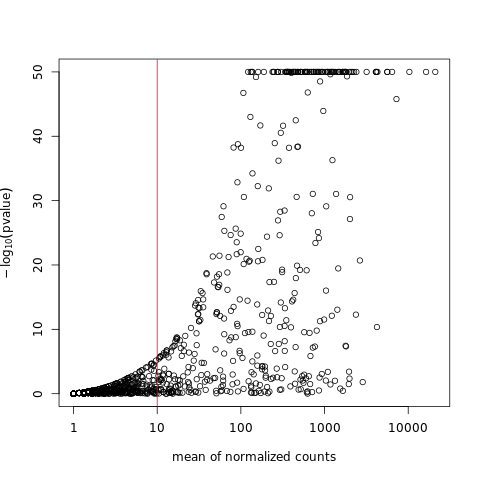

In [70]:
%%R
plot(res$baseMean, pmin(-log10(res$pvalue),50), log="x", xlab="mean of normalized counts", ylab=expression(-log[10](pvalue)))
abline(v=10,col="red",lwd=1)

In [71]:
%%R
use <- res$baseMean >= 10 & !is.na(res$pvalue)
resFilt <- res[use,]

In [72]:
%%R
dim(res)

[1] 1388    6


In [73]:
%%R
dim(resFilt)

[1] 441   6


You can visualize the normalized counts for a single gene across the groups (e.g. the one with the lowest pvalue)

In [74]:
%%R
head(resFilt)

log2 fold change (MLE): Group Tumor vs Normal 
Wald test p-value: Group Tumor vs Normal 
DataFrame with 6 rows and 6 columns
                           baseMean    log2FoldChange              lfcSE
                          <numeric>         <numeric>          <numeric>
ENSG00000197077.13 1145.16666666667  2.77475699225537 0.0630456555423005
ENSG00000100077.15 1517.33333333333 -1.93530481826335  0.049007958178949
ENSG00000100219.16 4157.66666666667  2.20267610268545 0.0303955907470057
ENSG00000186998.16 1024.33333333333 -3.58750735212243 0.0786042968438936
ENSG00000100234.11 4290.83333333333  9.65020991330315  0.255824251724647
ENSG00000100320.23 2402.66666666667  7.65851313277117  0.173560423699882
                                stat    pvalue      padj
                           <numeric> <numeric> <numeric>
ENSG00000197077.13  44.0118667715913         0         0
ENSG00000100077.15 -39.4896031211243         0         0
ENSG00000100219.16   72.466961442506         0         0
ENSG00

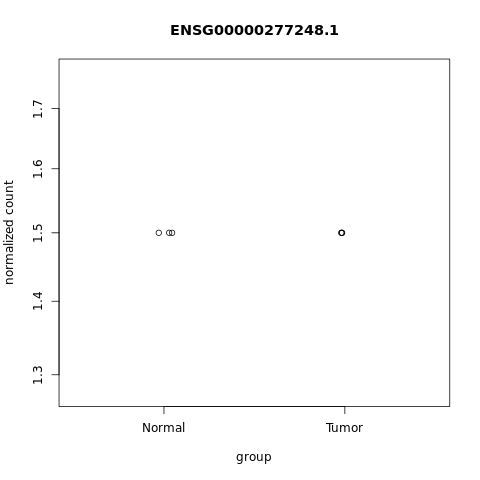

In [75]:
%%R
plotCounts(dds, gene=which.min(resFilt$padj), intgroup="Group")

Convert object “resFilt” (filtered dataset) into a dataframe (“r”) so that you can save it later as a .csv file and be able to look at it in Excel.

In [76]:
%%R
r <- as.data.frame(resFilt)

In [77]:
%%R
write.csv(r,"filtered_results.csv")

When you are ready (you can leave this to the end of the practical when you have finished using R in the next section) open the spread sheet in Excel and identify significantly differentially expressed genes between tumour and normal samples by applying various filters (log2fold changes, p-values, gene biotype). 

## Data Transformation

It is common practice to transform read counts to analyze these gene expression data for purposes other than differential expression, such as clustering and co-expression networks or any use in regression models where homoskedasticity (having constant variance along the range of mean values) is required. In this case DESeq2 offers a function called variance-stabilizing transformation (VST).

In [78]:
%%R
newdata <- getVarianceStabilizedData(dds)

In [79]:
%%R
head(newdata)

                  hcc1395.normal.rep1Aligned.sortedByCoord.out.bam
ENSG00000277248.1                                         16.37828
ENSG00000283047.1                                         16.37828
ENSG00000279973.2                                         16.37828
ENSG00000226444.2                                         16.37828
ENSG00000276871.1                                         16.37828
ENSG00000288262.1                                         16.38033
                  hcc1395.normal.rep2Aligned.sortedByCoord.out.bam
ENSG00000277248.1                                         16.37828
ENSG00000283047.1                                         16.37828
ENSG00000279973.2                                         16.37828
ENSG00000226444.2                                         16.37828
ENSG00000276871.1                                         16.37828
ENSG00000288262.1                                         16.38033
                  hcc1395.normal.rep3Aligned.sortedByCoord.out

## Heatmap Of Distances And Principal Component

We can visualize the sample-to-sample distances along with similarities and dissimilarities with a heatmap of variance-stabilized data.

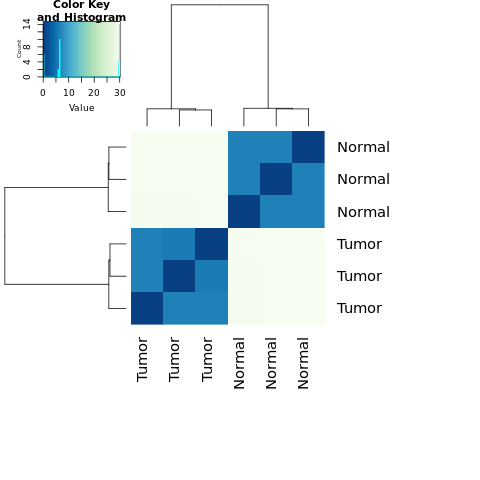

In [80]:
%%R
vst <- varianceStabilizingTransformation(dds, blind=TRUE)
distsRL <- dist(t(assay(vst)))
mat <- as.matrix(distsRL)
rownames(mat)<- colnames(mat)<-with(colData(dds),paste(Group))
hmcol <- colorRampPalette(brewer.pal(9, "GnBu"))(100)
heatmap.2(mat, trace="none", col = rev(hmcol), margin=c(13, 13))

Create a PCA plot for these variance-stabilized data. 

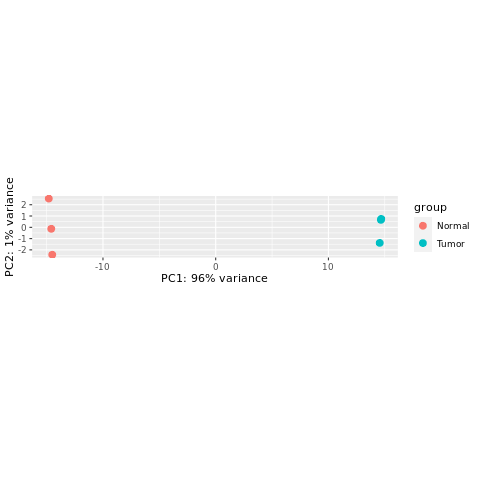

In [81]:
%%R
print(plotPCA(vst, intgroup="Group"))

Now that you have finished using R, you can go back and look at the spreadsheet that we have prepared for you.  If you have not already done so, copy the spreadsheet `Differential_Expression_Results.csv` to a PC desktop and open it using Excel.

When you have finished, don’t forget to close the browser.  